In [346]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

## Importing the Dataset

In [347]:
df = pd.read_csv("final_df.csv")
df.head()

,Hotels,Ratings,Price,Promotion,Description,Link,Place,From Date,To Day
0,Casa Abamita,8.5,€ 740,Only 1 room left at this price on our site,Double or Twin Room Without Views - Disability...,https://www.booking.com/hotel/es/mayerling-aba...,Barcelona,2024-05-23,2024-05-26
1,Le Palacete powered by Sonder,8.1,€ 925,Only 1 room left at this price on our site,King Room\n1 extra-large double bed\nOnly 1 ro...,https://www.booking.com/hotel/es/le-palacete.e...,Barcelona,2024-05-23,2024-05-26
2,Motel One Barcelona-Ciutadella,8.8,€ 605,NaN,Double Room\n1 double bed\nFree cancellation\n...,https://www.booking.com/hotel/es/motel-one-bar...,Barcelona,2024-05-23,2024-05-26
3,TWO Hotel Barcelona by Axel 4* Sup- Adults Only,8.4,€ 610,NaN,Double or Twin Room\n1 large double bed\n3 nig...,https://www.booking.com/hotel/es/two-barcelona...,Barcelona,2024-05-23,2024-05-26
4,Inside Barcelona Apartments Sants,8.6,€ 494,NaN,Studio (2 Adults)\nEntire apartment • 1 bedroo...,https://www.booking.com/hotel/es/inside-bcn-ap...,Barcelona,2024-05-23,2024-05-26


Converting Prices to Integers.

In [348]:
df['Price'] = df['Price'].replace('[^0-9]', '', regex=True)
df.dropna(subset=['Price'], inplace=True)

df['Price'] = df['Price'].astype(int)

Dates are binary encoded:  
1 is for the weekend of Primavera  
0 is our control weekend  

Binary encoding for cities:  
1 is for Barcelona  
0 is for Valencia  

In [349]:

dates = df["From Date"].unique()
date_mapping, date_index = pd.factorize(df["From Date"])

df["From Date"] = date_mapping

In [350]:
df["Place"] = 1 - pd.get_dummies(data =  df["Place"], columns = "Place", drop_first= True, dtype = int)

In [351]:
df = df.drop(["Link", "Hotels", "To Day"], axis = 1)

## Descriptive Statistics

In [352]:
valencia = df[df["Place"] == 0]
barcelona = df[df["Place"] == 1]

valPrima = valencia[valencia["From Date"]==1]
bcnPrima = barcelona[barcelona["From Date"]==1]

print('CONTROL WEEKEND:')
print(f'Hotels in Valencia: {valencia.shape[0] - valPrima.shape[0]}')
print(f'Hotels in Barcelona: {barcelona.shape[0] - bcnPrima.shape[0]}')
print("")
print('PRIMAVERA WEEKEND:')
print(f'Hotels in Valencia: {valPrima.shape[0]}')
print(f'Hotels in Barcelona: {bcnPrima.shape[0]}')


CONTROL WEEKEND:
Hotels in Valencia: 861
Hotels in Barcelona: 1005

PRIMAVERA WEEKEND:
Hotels in Valencia: 573
Hotels in Barcelona: 1001


In [353]:
val_mean = valencia['Ratings'].mean()
val_median = valencia['Ratings'].median()
val_var = valencia['Ratings'].var()

print(f'Mean Rating of Hotels in Valencia: {round(val_mean,2)}')
print(f'Median Rating of Hotels in Valencia: {round(val_median,2)}')
print(f'Rating Variance in Valencia: {round(val_var,2)}')

Mean Rating of Hotels in Valencia: 8.2
Median Rating of Hotels in Valencia: 8.3
Rating Variance in Valencia: 1.05


In [354]:
bcn_mean = barcelona['Ratings'].mean()
bcn_median = barcelona['Ratings'].median()
bcn_var = barcelona['Ratings'].var()

print(f'Mean Rating of Hotels in Barcelona: {round(bcn_mean,2)}')
print(f'Median Rating of Hotels in Barcelona: {round(bcn_median,2)}')
print(f'Rating Variance in Barcelona: {round(bcn_var,2)}')

Mean Rating of Hotels in Barcelona: 8.06
Median Rating of Hotels in Barcelona: 8.3
Rating Variance in Barcelona: 0.95


# Regressions

## Barcelona: Primavera vs Weekend Before

In [355]:
Regress1 = df[df["Place"] == 1][["From Date", "Price"]]
Regress1.head()

,From Date,Price
0,0,740
1,0,925
2,0,605
3,0,610
4,0,494


In [356]:
Regress1[Regress1["From Date"] == 1]["Price"].mean() - Regress1[Regress1["From Date"] == 0]["Price"].mean()

497.10004920452684

In [357]:
lr = LinearRegression()
lr.fit(Regress1[["From Date"]], Regress1["Price"])

LinearRegression()

In [358]:
b = lr.intercept_
m = lr.coef_

print(f'Intercept (Average Price of Control Group): ${round(b, 2)}')
print(f'Slope (Effect Estimate): ${round(m[0], 2)}')

Intercept (Average Price of Control Group): $809.54
Slope (Effect Estimate): $497.1


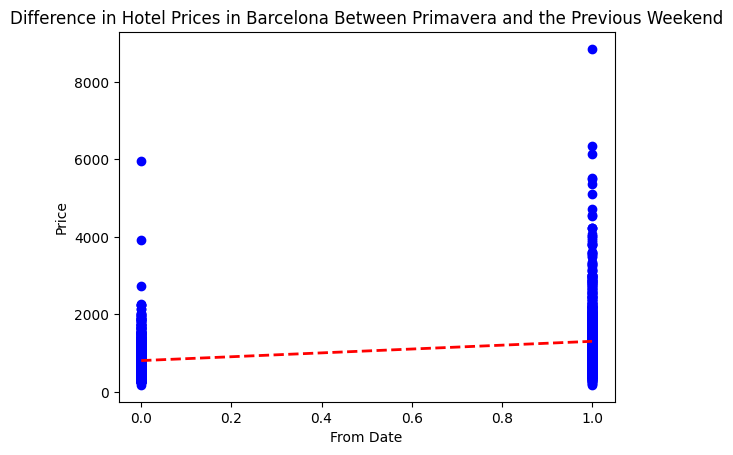

In [359]:
plt.scatter(Regress1["From Date"], Regress1["Price"], color='blue', label='Data')
plt.plot(Regress1["From Date"], lr.predict(Regress1[["From Date"]]), color='red', linewidth=2,linestyle="dashed", label='Regression Line')

plt.xlabel('From Date')
plt.ylabel('Price')
plt.title("Difference in Hotel Prices in Barcelona Between Primavera and the Previous Weekend")
plt.show()

## Primavera Weekend: Valencia vs Barcelona

In [360]:
Regress2 = df[df["From Date"] == 1]

In [361]:
y2 = Regress2["Price"]
X2 = Regress2[["Place"]]

lr2 = LinearRegression()
lr2.fit(X2, y2)

LinearRegression()

In [362]:
b = lr2.intercept_
m = lr2.coef_

print(f'Intercept (Average Price of Control Group): ${round(b, 2)}')
print(f'Slope (Effect Estimate): ${round(m[0], 2)}')

Intercept (Average Price of Control Group): $727.97
Slope (Effect Estimate): $578.67


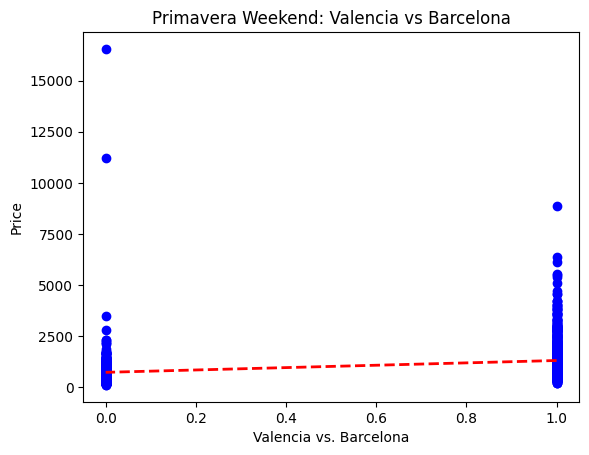

In [363]:
plt.scatter(Regress2["Place"], Regress2["Price"], color='blue', label='Valencia')
plt.plot(Regress2["Place"], lr2.predict(X2), color='red', linewidth=2, linestyle ="dashed")

plt.xlabel('Valencia vs. Barcelona')
plt.ylabel('Price')
plt.title("Primavera Weekend: Valencia vs Barcelona")
plt.show()

## Difference In Difference Estimator:

In [364]:
df["Interaction"] = df["Place"] * df["From Date"]

regress3 = df.drop(["Ratings", "Promotion", "Description"], axis = 1)


In [365]:
diffRegress = LinearRegression()
diffRegress.fit(regress3.iloc[:,1:], regress3["Price"])

LinearRegression()

In [366]:
diffRegress.intercept_

631.9268292682901

In [367]:
diffRegress.coef_

array([177.61048416,  96.04001192, 401.06003729])

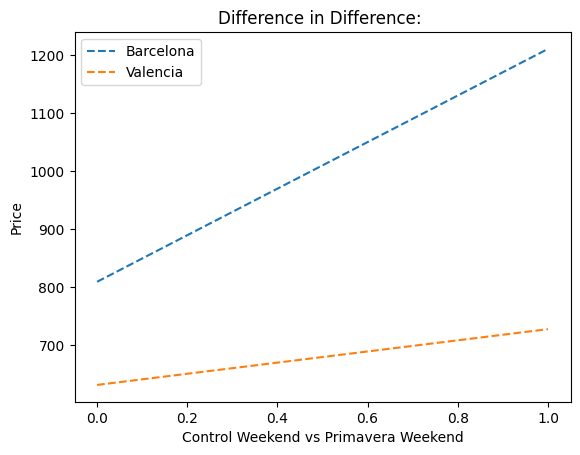

In [368]:

x_values = np.linspace(0, 1, 100)  # Adjust the range as needed

# Calculate corresponding y values using the equation
val_values = 631.93 + 96.04001192 * x_values
bcn_values = 631.93 + 177.61 + 401.06 * x_values

# Plot the graph


plt.plot(x_values, bcn_values, label='Barcelona', linestyle = "dashed")
plt.plot(x_values, val_values, label='Valencia', linestyle = "dashed")

plt.xlabel('Control Weekend vs Primavera Weekend')
plt.legend(loc ="upper left")
plt.ylabel('Price')
plt.title("Difference in Difference: ")
plt.show()

In [369]:
regress3.iloc[:,1:].columns
diffRegress.coef_

array([177.61048416,  96.04001192, 401.06003729])

In [370]:
print(f'Control Effect: {round(diffRegress.coef_[-2],2)}')
print(f'Treatment Effect: {round(diffRegress.coef_[0],2)}')
print(f'Primavera Effect: {round(diffRegress.coef_[-1], 2)}')

Control Effect: 96.04
Treatment Effect: 177.61
Primavera Effect: 401.06


## With Text Features

In [371]:
dtm = pd.read_csv("final_dtm.csv", index_col= 0)
dtm.head()

,adult original,adult original price,apartment,apartment bedroom,apartment bedroom bathroom,apartment bedroom living,apartment entire,apartment entire apartment,bathroom,bathroom kitchen,...,single,single double,site,site night,site night adult,sofa,sofa bed,sofa bed free,twin,twin room
0,1,1,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,1,1,1,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0


In [372]:
dtm.columns

Index(['adult original', 'adult original price', 'apartment',
       'apartment bedroom', 'apartment bedroom bathroom',
       'apartment bedroom living', 'apartment entire',
       'apartment entire apartment', 'bathroom', 'bathroom kitchen',
       'bathroom kitchen m²', 'bed double', 'bed double single',
       'bed double sofa', 'bed free', 'bed free cancellation', 'bed leave',
       'bed leave price', 'bed night', 'bed night adult', 'bed room',
       'bed room leave', 'bed single', 'bed single double', 'bedroom',
       'bedroom apartment', 'bedroom apartment entire', 'bedroom bathroom',
       'bedroom living', 'bedroom living room', 'cancellation',
       'cancellation night', 'cancellation night adult', 'current',
       'current price', 'current price include', 'double bed', 'double free',
       'double free cancellation', 'double room', 'double single',
       'double sofa', 'double sofa bed', 'double twin', 'double twin room',
       'entire', 'entire apartment', 'entire 

In [373]:
choosen_variables = ["free cancellation","entire apartment"]
text_features = dtm[choosen_variables]

colnames = list(df.columns)+ list(text_features.columns)

In [374]:
df.reset_index(drop=True, inplace=True)
text_features.reset_index(drop=True, inplace=True)
df_text = pd.concat([df, text_features], axis=1, ignore_index=True)
df_text.columns = colnames
df_text.head()

,Ratings,Price,Promotion,Description,Place,From Date,Interaction,free cancellation,entire apartment
0,8.5,740,Only 1 room left at this price on our site,Double or Twin Room Without Views - Disability...,1,0,0,1,0
1,8.1,925,Only 1 room left at this price on our site,King Room\n1 extra-large double bed\nOnly 1 ro...,1,0,0,0,0
2,8.8,605,NaN,Double Room\n1 double bed\nFree cancellation\n...,1,0,0,1,0
3,8.4,610,NaN,Double or Twin Room\n1 large double bed\n3 nig...,1,0,0,0,0
4,8.6,494,NaN,Studio (2 Adults)\nEntire apartment • 1 bedroo...,1,0,0,0,1


In [375]:
final_df = df_text.drop(["Description","Ratings"], axis= 1)
final_df['Promotion'] = final_df['Promotion'].apply(lambda x: 1 if pd.notna(x) else 0).astype(int)
final_df.head()

,Price,Promotion,Place,From Date,Interaction,free cancellation,entire apartment
0,740,1,1,0,0,1,0
1,925,1,1,0,0,0,0
2,605,0,1,0,0,1,0
3,610,0,1,0,0,0,0
4,494,0,1,0,0,0,1


In [376]:
model4 = LinearRegression()
model4.fit(final_df.iloc[:,1:], final_df["Price"])
coefs = pd.DataFrame(model4.coef_).T
coefs.columns = final_df.columns[1:]

print(f'Intercept: {round(model4.intercept_,2)}')
print(r'Coefficients:')
coefs


Intercept: 428.66
Coefficients:


,Promotion,Place,From Date,Interaction,free cancellation,entire apartment
0,-114.814474,284.756263,101.352867,399.484215,141.720202,341.089329
